# Bike Boulevards

## 00 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import LineString
import shapely as shp
import uuid
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

## 01 Data Preparation

### Bike Network

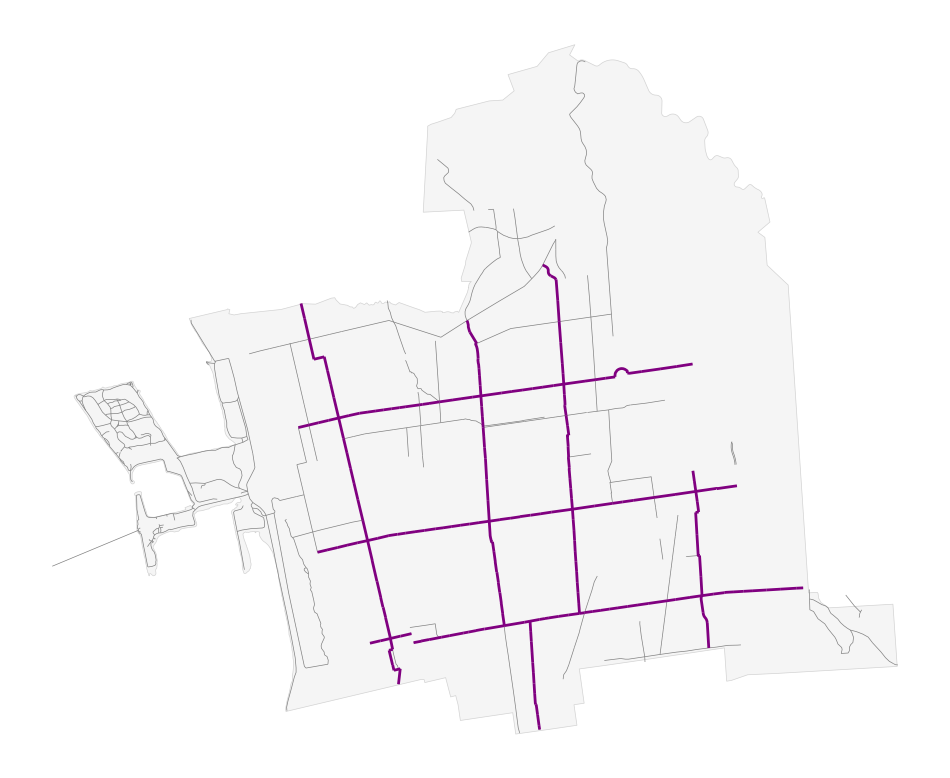

In [74]:
bike_network = gpd.read_file("data/Berkeley_ExistingBikeways.shp")
city_bound = gpd.read_file("data/CityBoundary_clipped.shp")


bblvd = bike_network[(bike_network["BBlvdNetwo"] == 'Y')].copy()

fig, ax = plt.subplots(figsize=(12,12))
bike_network.plot(ax=ax, edgecolor='gray', linewidth=.5).set_axis_off()
bblvd.plot(ax=ax, edgecolor='purple', linewidth=2)
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5)
plt.savefig('bblvd_map.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Collision Data - All Modes

<Axes: >

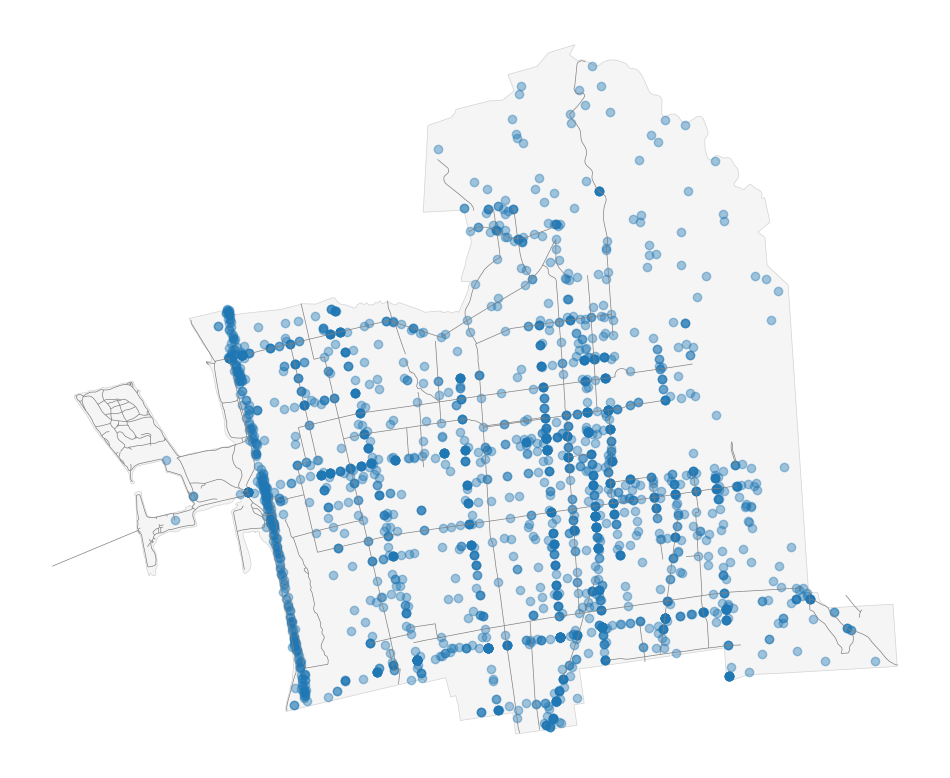

In [75]:
table = pd.read_csv("data/tims_collisions_berkeley_2018_2022_all_modes.csv")
all_modes = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(table.LONGITUDE, table.LATITUDE, crs="EPSG:4326"), data=table
)
all_modes = all_modes.to_crs(bike_network.crs)
all_modes = gpd.sjoin(all_modes, city_bound, how = 'inner')

fig, ax = plt.subplots(figsize=(12,12))
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5).set_axis_off()
bike_network.plot(ax=ax, edgecolor='gray', linewidth=.5).set_axis_off()
all_modes.plot(ax=ax, alpha=0.4)
#plt.savefig('all_modes_map.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Collision Data - Bike and Pedestrian

<Axes: >

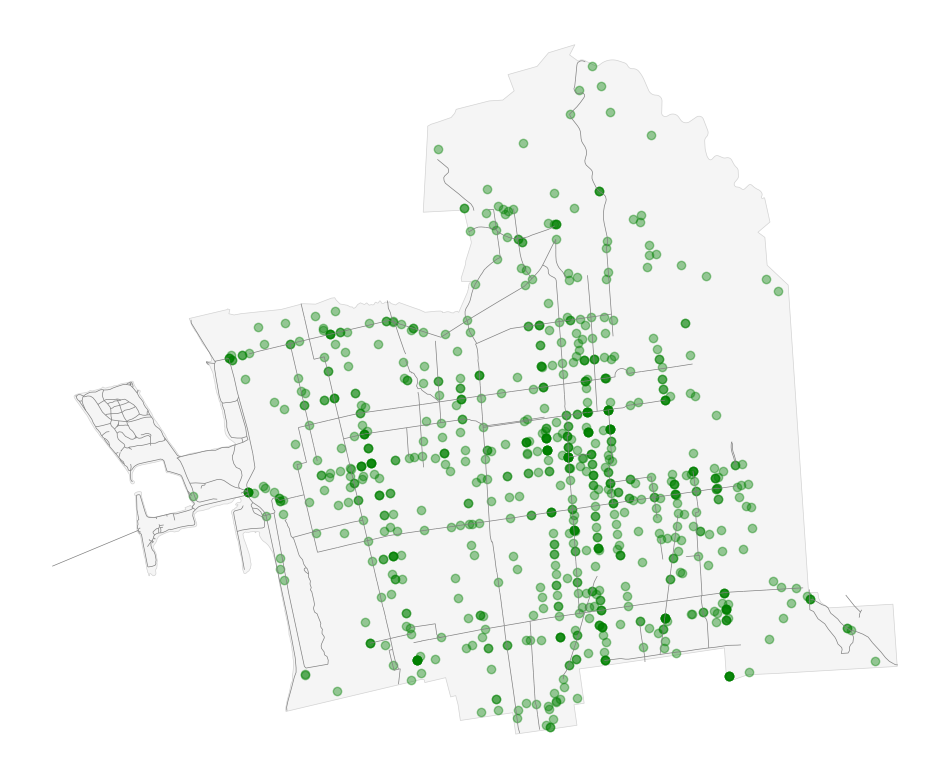

In [76]:
bike_ped = all_modes[(all_modes["PEDESTRIAN_ACCIDENT"] == 'Y') | (all_modes["BICYCLE_ACCIDENT"] == 'Y')]

fig, ax = plt.subplots(figsize=(12,12))
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5).set_axis_off()
bike_network.plot(ax=ax, edgecolor='gray', linewidth=.5).set_axis_off()
bike_ped.plot(ax=ax, color='green', alpha=0.4)

## 02 Collision Density

#### Step 1: Calculate Length of Bike Boulevard Segements and Add Unique ID Column

In [77]:
bblvd['length_feet']=bblvd.geometry.length
bblvd['unique_id']= [uuid.uuid4() for _ in range(len(bblvd))]
bblvd.head()

,BB_STRNAM,BB_FRO,BB_TO,DIR_,ALT_bikeCA,Existing_A,Subtype_,Pavement_C,Notes,Creator,...,Parking_11,Parking_2_,Parking_21,BBlvdNetwo,MILES,Shape_Leng,Name,geometry,length_feet,unique_id
0,Russell,7th,8th,E/W,No,3e Bike Boulevard,None,Smooth,None,altaplanning,...,Parallel,WB,Parallel,Y,0.062856,331.878586,None,"LINESTRING (6044346.223 2138189.126, 6044669.2...",331.878586,d9400450-0312-47fe-ad33-d3011081627c
1,Russell,8th,9th,E/W,No,3e Bike Boulevard,None,Smooth,None,altaplanning,...,Parallel,WB,Parallel,Y,0.062660,330.847618,None,"LINESTRING (6044673.000 2138263.499, 6044995.0...",330.847618,4b675c57-b991-46c4-ac81-5ebd76bd5f5b
2,Russell,9th,10th,E/W,No,3e Bike Boulevard,None,Rough,None,altaplanning,...,Parallel,WB,Parallel,Y,0.062178,328.298900,None,"LINESTRING (6044995.000 2138339.499, 6045314.5...",328.298900,3df7a288-576d-4004-8e23-fb2027bb4564
3,Russell,10th,San Pablo,E/W,No,3e Bike Boulevard,None,Rough,None,altaplanning,...,Parallel,WB,Parallel,Y,0.066252,349.812336,None,"LINESTRING (6045318.277 2138413.120, 6045658.9...",349.812336,74ebcb4b-f176-403c-a459-5629e49b7196
4,Russell,San Pablo,Wallace,E/W,3,3e Bike Boulevard,None,Acceptable,None,altaplanning,...,Parallel,WB,Parallel,Y,0.047832,252.554439,None,"LINESTRING (6045725.278 2138206.121, 6045973.2...",252.554439,fc7efb9b-4e77-49ba-8e40-ebfd46b6bd0c


#### Step 2: Buffer Bike Boulevard Segments by 100ft

<Axes: >

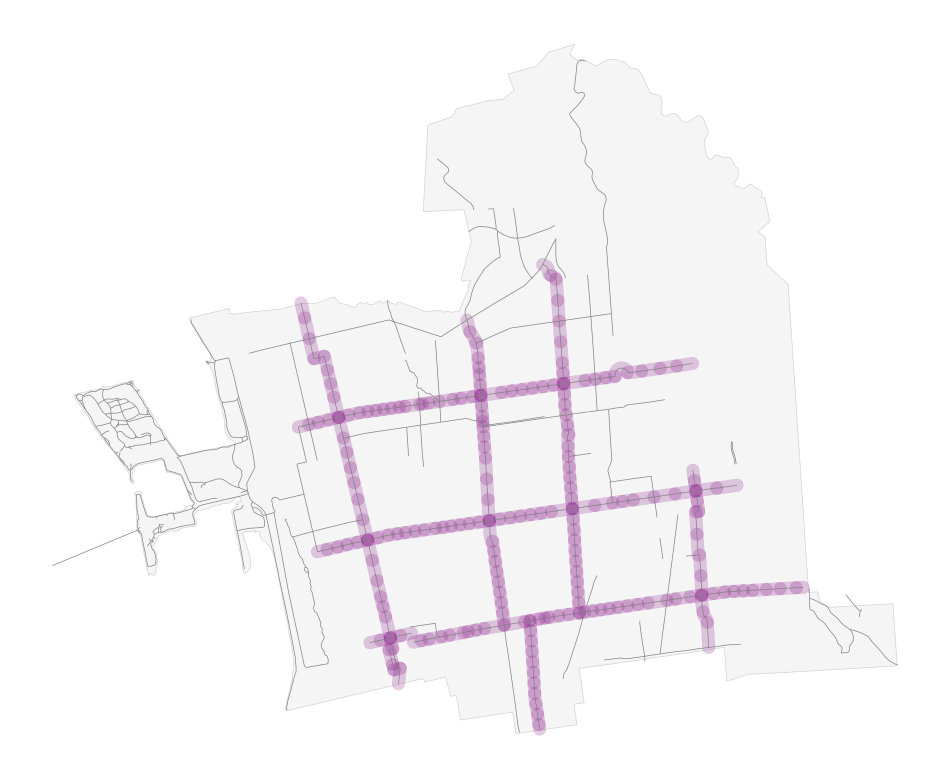

In [78]:
buff_dist = 200
bblvd['buff_geometry'] = bblvd['geometry'].buffer(buff_dist)

bblvd.set_geometry('buff_geometry', inplace = True)

fig, ax = plt.subplots(figsize=(12,12))
bike_network.plot(ax=ax, edgecolor='gray', linewidth=.5).set_axis_off()
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5)
bblvd.plot(ax=ax, color='purple', edgecolor='purple', alpha=.2, linewidth=.2)

#### Step 3: Spatial Join

##### a. spatial join collision points to bike boulevard buffers

In [79]:
bike_ped_v2 = bike_ped.copy()
bike_ped_v2 = bike_ped_v2.drop(['index_right'], axis=1)
all_modes_v2 =all_modes.copy()
all_modes_v2 = all_modes_v2.drop(['index_right'], axis=1)
bblvd_v3 = bblvd.copy()

bp_points_in_buff = gpd.sjoin(bike_ped_v2, bblvd_v3, how="inner", predicate='intersects')
bp_points_in_buff['bp_point_count']=1
bp_points_in_buff = bp_points_in_buff.groupby('unique_id').agg({'CASE_ID':'first', 'geometry_right':'first', 'length_feet':'first','bp_point_count':'sum'}).reset_index()


all_points_in_buff = gpd.sjoin(all_modes_v2, bblvd_v3, how="inner", predicate='intersects')
all_points_in_buff['all_point_count']=1
all_points_in_buff = all_points_in_buff.groupby('unique_id').agg({'CASE_ID':'first', 'geometry_right':'first', 'length_feet':'first','all_point_count':'sum'}).reset_index()

all_points_in_buff.head()

,unique_id,CASE_ID,geometry_right,length_feet,all_point_count
0,0241e08f-d7d9-4bbd-a2f5-9e596de8d2c5,8779557,"LINESTRING (6049429.001 2138570.750, 6049450.0...",328.922365,6
1,027af311-e421-4dd2-aae3-58cf579bde48,9049311,"LINESTRING (6043203.999 2145954.249, 6043356.5...",659.622044,3
2,029d73ff-c7bd-4a8f-abde-a129654b159d,8742982,"LINESTRING (6043840.002 2143253.999, 6043963.9...",541.633718,6
3,062f35d6-5546-49c1-8264-9c7b6e350047,8811291,"LINESTRING (6054769.999 2140964.500, 6054812.0...",658.841485,1
4,08776ad2-de1d-452d-9163-bfe65a3f2db6,8643163,"LINESTRING (6051795.499 2146569.750, 6052099.4...",306.885284,9


##### b. table join point count columns and calculate collision density

In [80]:
joined_table = bp_points_in_buff.merge(all_points_in_buff, on='unique_id', how='left')
joined_table['collision_density_per_ft'] = (joined_table['bp_point_count'] / joined_table['all_point_count']) / joined_table['length_feet_x']
joined_table.head()

,unique_id,CASE_ID_x,geometry_right_x,length_feet_x,bp_point_count,CASE_ID_y,geometry_right_y,length_feet_y,all_point_count,collision_density_per_ft
0,0241e08f-d7d9-4bbd-a2f5-9e596de8d2c5,9212563,"LINESTRING (6049429.001 2138570.750, 6049450.0...",328.922365,2,8779557,"LINESTRING (6049429.001 2138570.750, 6049450.0...",328.922365,6,0.001013
1,027af311-e421-4dd2-aae3-58cf579bde48,9049311,"LINESTRING (6043203.999 2145954.249, 6043356.5...",659.622044,3,9049311,"LINESTRING (6043203.999 2145954.249, 6043356.5...",659.622044,3,0.001516
2,029d73ff-c7bd-4a8f-abde-a129654b159d,8742982,"LINESTRING (6043840.002 2143253.999, 6043963.9...",541.633718,5,8742982,"LINESTRING (6043840.002 2143253.999, 6043963.9...",541.633718,6,0.001539
3,062f35d6-5546-49c1-8264-9c7b6e350047,8811291,"LINESTRING (6054769.999 2140964.500, 6054812.0...",658.841485,1,8811291,"LINESTRING (6054769.999 2140964.500, 6054812.0...",658.841485,1,0.001518
4,08776ad2-de1d-452d-9163-bfe65a3f2db6,8841478,"LINESTRING (6051795.499 2146569.750, 6052099.4...",306.885284,4,8643163,"LINESTRING (6051795.499 2146569.750, 6052099.4...",306.885284,9,0.001448


C:\Users\lssch\windows\envs\geo_env\Lib\site-packages\geopandas\plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


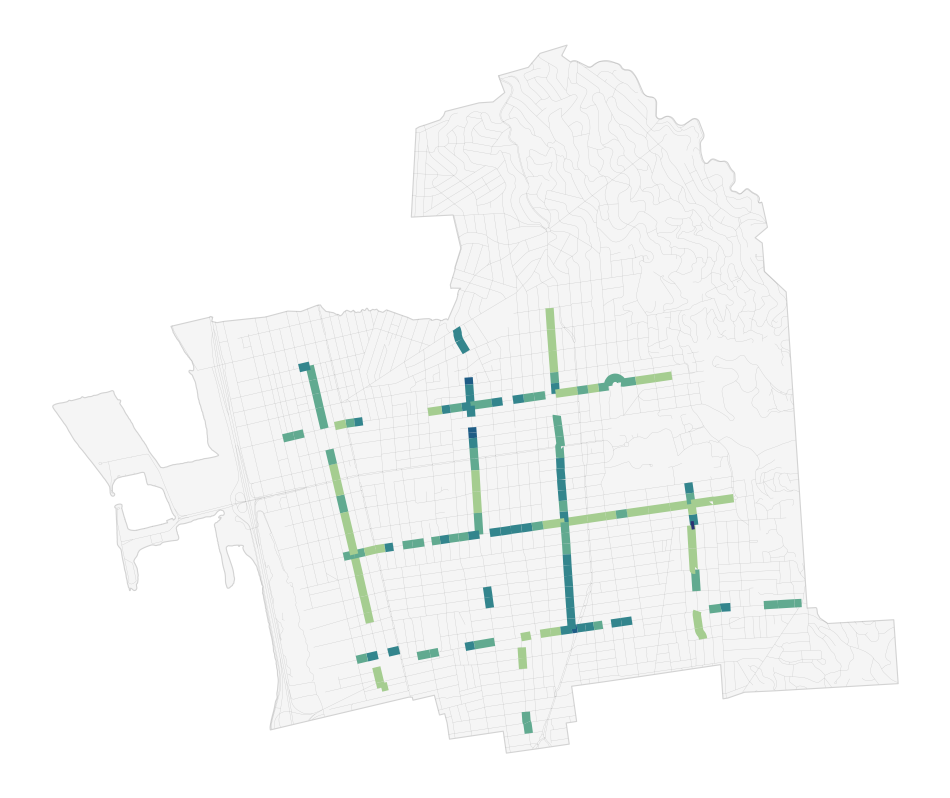

In [92]:
collision_density = gpd.GeoDataFrame(joined_table, crs="EPSG:4326", geometry='geometry_right_x')

import seaborn as sns
cmap = sns.color_palette("crest", as_cmap=True)

centerline = gpd.read_file("data/Centerline.shp")

fig, ax = plt.subplots(figsize=(12,12))
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.8).set_axis_off()
centerline.plot(ax=ax, edgecolor='gray', alpha=.4, linewidth=.2)
collision_density.plot(ax=ax, column='collision_density_per_ft', scheme="Fisher_Jenks", cmap=cmap, linewidth = 6, aspect=1, legend=False)
#plt.legend(['Lower Density', 'Higher Density'])

plt.savefig('density_map.png', dpi=600, bbox_inches='tight', pad_inches=0)

#### Step 4: Tabular Join Buffered Segments Back to Line Segments, Calculate ratio of bikeped to all modes per 500ft segment

## 03 Charts

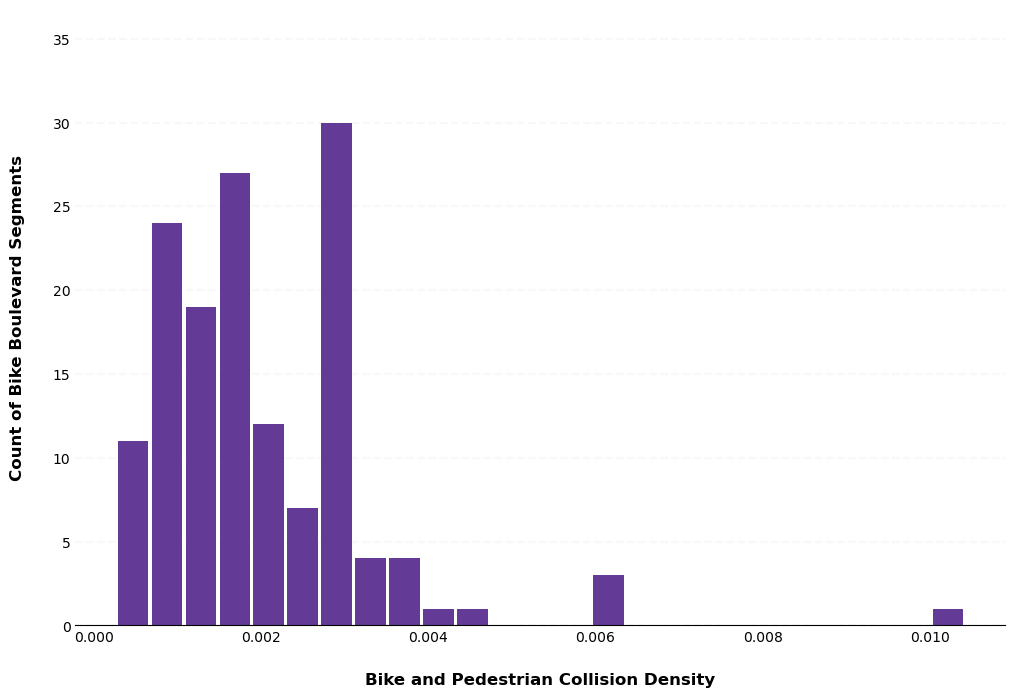

In [82]:
ax = collision_density.hist(column='collision_density_per_ft', bins=25, grid=False, figsize=(12,8), color='#633B97', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.set_title("")
    x.set_xlabel("Bike and Pedestrian Collision Density", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count of Bike Boulevard Segments", labelpad=20, weight='bold', size=12)

#plt.savefig('density_histogram.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [83]:
bblvd_summary = bblvd.merge(collision_density, on='unique_id', how='left')
bblvd_summary.groupby('BB_STRNAM', as_index=False)['collision_density_per_ft'].mean().sort_values(by=['collision_density_per_ft'], ascending=False)

,BB_STRNAM,collision_density_per_ft
3,California,0.002928
5,Hillegass,0.002548
8,Russell,0.002454
7,Milvia,0.002278
2,Bowditch,0.002099
9,Virginia,0.001783
4,Channing,0.001630
6,King,0.001248
1,9th,0.001215
0,8th,NaN


In [91]:
collision_density.describe()

,CASE_ID_x,length_feet_x,bp_point_count,CASE_ID_y,length_feet_y,all_point_count,collision_density_per_ft
count,1.440000e+02,144.000000,144.0000,1.440000e+02,144.000000,144.000000,144.000000
mean,8.920001e+06,395.054814,2.5625,8.857477e+06,395.054814,4.451389,0.002025
std,2.774674e+05,144.807165,2.1278,2.558639e+05,144.807165,3.663904,0.001334
min,8.595473e+06,95.988418,1.0000,8.595465e+06,95.988418,1.000000,0.000263
25%,8.648826e+06,324.484795,1.0000,8.641119e+06,324.484795,2.000000,0.001122
50%,8.836088e+06,331.844122,2.0000,8.807328e+06,331.844122,3.000000,0.001596
75%,9.058155e+06,460.452513,3.0000,9.001796e+06,460.452513,6.000000,0.002995
max,9.546095e+06,711.603779,13.0000,9.546095e+06,711.603779,15.000000,0.010418


In [121]:
collision_density.sort_values(by=['collision_density_per_ft'], ascending=False)



,unique_id,CASE_ID_x,geometry_right_x,length_feet_x,bp_point_count,CASE_ID_y,geometry_right_y,length_feet_y,all_point_count,collision_density_per_ft
71,7e1c8090-34b9-4857-b9d2-1db7f4d1053d,9364086,"LINESTRING (6054741.49987 2142338.50042, 60546...",95.988418,1,9364086,"LINESTRING (6054741.500 2142338.500, 6054646.5...",95.988418,1,0.010418
63,72c4269b-2be6-45da-bdfc-d506ec59600f,8595485,"LINESTRING (6050973.00084 2139130.99929, 60511...",162.598510,2,8595485,"LINESTRING (6050973.001 2139130.999, 6051134.0...",162.598510,2,0.006150
23,2a00ce5e-f662-44c3-ad56-e11a19f3b8e4,8971567,"LINESTRING (6047902.00141 2145348.74899, 60479...",163.660415,1,8971567,"LINESTRING (6047902.001 2145348.749, 6047913.6...",163.660415,1,0.006110
114,cd373519-f708-4873-9aa1-8d6661199c66,8971567,"LINESTRING (6047913.62605 2145185.50194, 60479...",167.176501,1,8971567,"LINESTRING (6047913.626 2145185.502, 6047925.5...",167.176501,1,0.005982
45,53e47332-4210-407d-9966-c045ce093efd,9277048,"LINESTRING (6047793.49998 2146885.24887, 60478...",218.837295,3,9277048,"LINESTRING (6047793.500 2146885.249, 6047809.5...",218.837295,3,0.004570
...,...,...,...,...,...,...,...,...,...,...
43,50374e8e-9b8b-4e59-ad84-3c133a35699b,8648826,"LINESTRING (6054840.00131 2139692.49849, 60548...",531.164502,2,8595465,"LINESTRING (6054840.001 2139692.498, 6054825.0...",531.164502,8,0.000471
133,f1b636fe-706b-46a6-8bfe-9f7984f55a52,9386586,"LINESTRING (6053523.49935 2146863.99924, 60540...",532.211238,1,8641115,"LINESTRING (6053523.499 2146863.999, 6054050.0...",532.211238,4,0.000470
140,fceae9d1-edd4-4c71-b8a7-5172ff8a0016,9386586,"LINESTRING (6052940.99953 2146781.24973, 60535...",588.348128,1,8641115,"LINESTRING (6052941.000 2146781.250, 6053523.4...",588.348128,4,0.000425
10,1a99615c-df04-4149-aff7-7c1899b2678c,8965103,"LINESTRING (6044417.22360 2140794.62818, 60445...",662.005987,1,8737270,"LINESTRING (6044417.224 2140794.628, 6044565.2...",662.005987,4,0.000378


In [84]:
bblvd_v4 = bike_network[(bike_network["BBlvdNetwo"] == 'Y')].copy()
not_bblvd = bike_network[(bike_network["BBlvdNetwo"].isna()) & ((bike_network["Existing_A"] != '1a Paved Path') & (bike_network["Existing_A"] != '1b Unpaved Path'))]
bike_ped_v3 = all_modes[(all_modes["PEDESTRIAN_ACCIDENT"] == 'Y') | (all_modes["BICYCLE_ACCIDENT"] == 'Y')].copy()



In [129]:
outlier_summary = bblvd.merge(collision_density, on='unique_id', how='left')
#outlier_summary = outlier_summary['unique_id'] == '7e1c8090-34b9-4857-b9d2-1db7f4d1053d'



outlier_summary.set_geometry('buff_geometry', inplace = True)

outlier = outlier_summary[outlier_summary.collision_density_per_ft > .008]
outlier.head()

outlier[['BB_STRNAM', 'bp_point_count', 'all_point_count', 'length_feet_x', 'collision_density_per_ft']]

,BB_STRNAM,bp_point_count,all_point_count,length_feet_x,collision_density_per_ft
216,Hillegass,1.0,1.0,95.988418,0.010418


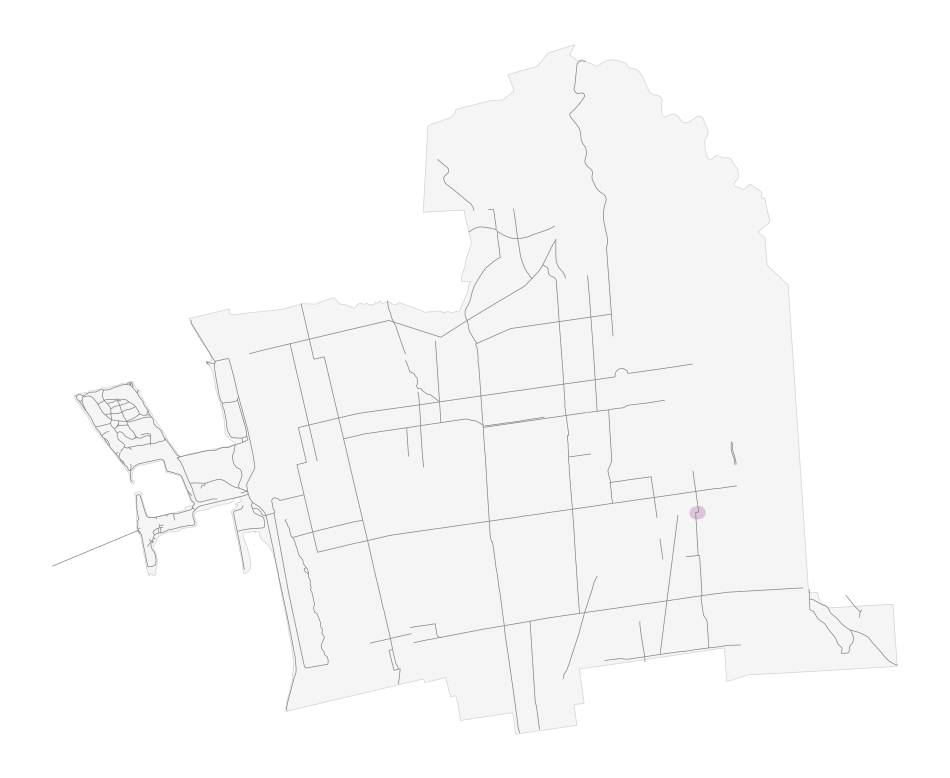

In [131]:
#collisions_in_outlier = 

fig, ax = plt.subplots(figsize=(12,12))
bike_network.plot(ax=ax, edgecolor='gray', linewidth=.5).set_axis_off()
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5)
outlier.plot(ax=ax, color='purple', edgecolor='purple', alpha=.2, linewidth=.2)

plt.savefig('outlier.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [85]:
bblvd_dissolve = bblvd_v4.dissolve(by='BBlvdNetwo')
not_bblvd_dissolve = not_bblvd.dissolve(by='Existing_A')

#fig, ax = plt.subplots(figsize=(12,12))
#not_bblvd_dissolve.plot(ax=ax, edgecolor='green', linewidth=1).set_axis_off()
#bblvd_dissolve.plot(ax=ax, edgecolor='purple', linewidth=2)
#city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5)

not_bblvd_dissolve.head()

,geometry,BB_STRNAM,BB_FRO,BB_TO,DIR_,ALT_bikeCA,Subtype_,Pavement_C,Notes,Creator,...,Creator_Da,Editor_Dat,Parking_1_,Parking_11,Parking_2_,Parking_21,BBlvdNetwo,MILES,Shape_Leng,Name
Existing_A,,,,,,,,,,,,,,,,,,,,,
2a Standard Bike Lane,"MULTILINESTRING ((6043076.261 2147957.706, 604...",Hopkins,Carlotta,McGee,N/S,2,None,Smooth,No lane on north side of street,altaplanning,...,2015-04-20,2015-06-11,WB,Parallel,EB,Parallel,None,0.071602,378.057390,None
2b Upgraded Bike Lane,"MULTILINESTRING ((6060244.199 2138198.851, 606...",None,None,None,None,2,Buffered (2b),Smooth,Only on WB lane,altaplanning,...,2015-04-20,2015-04-20,EB,Parallel,None,None,None,0.116993,617.724965,None
3a Signage Only Route,"MULTILINESTRING ((6053588.140 2138360.587, 605...",None,None,None,None,2,Signage Only Route (3a),Smooth,No potholes,altaplanning,...,2015-04-20,2015-04-22,NB,Parallel,SB,Parallel,None,0.051706,273.008196,None
3c Route with Pavement Stenciling,"MULTILINESTRING ((6058248.275 2139590.179, 605...",Gilman,San Pablo,Hopkins,None,3,Standard Sharrows (3c),Smooth,Only on WB lane,altaplanning,...,2015-04-20,2015-04-22,EB,Parallel,WB,Parallel,None,0.160709,848.542113,None
3e Bike Boulevard,"LINESTRING (6045609.501 2138686.000, 6045890.9...",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,0.253566,1338.828398,None


<Axes: >

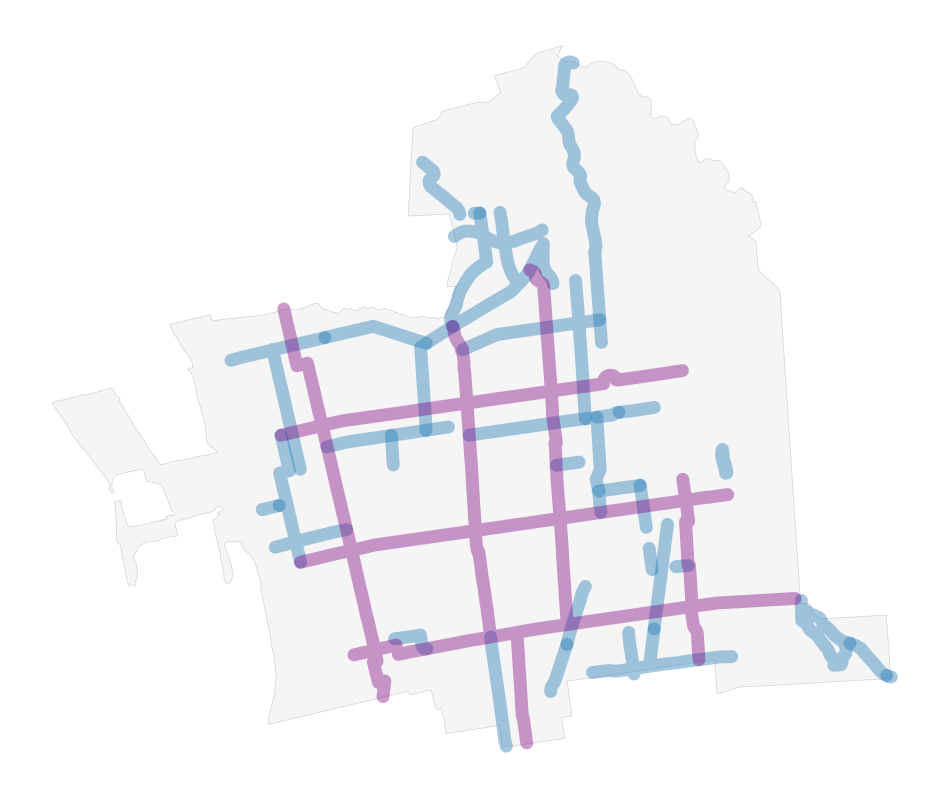

In [86]:
buff_dist = 200
bblvd_dissolve['buff_geometry'] = bblvd_dissolve['geometry'].buffer(buff_dist)
not_bblvd_dissolve['buff_geometry'] = not_bblvd_dissolve['geometry'].buffer(buff_dist)

bblvd_dissolve.set_geometry('buff_geometry', inplace = True)
not_bblvd_dissolve.set_geometry('buff_geometry', inplace = True)

fig, ax = plt.subplots(figsize=(12,12))
city_bound.plot(ax=ax, color='whitesmoke',edgecolor = "lightgrey", linewidth = 0.5)
not_bblvd_dissolve.plot(ax=ax, alpha=.4, linewidth=1).set_axis_off()
bblvd_dissolve.plot(ax=ax, color='purple', alpha=.4, linewidth=1)

In [87]:
bike_ped_v3 = bike_ped_v3.drop(['index_right'], axis=1)

bp_points_in_bblvd_2 = gpd.sjoin(bike_ped_v3, bblvd_dissolve, how="inner", predicate='intersects')
bp_points_in_bblvd_2['bp_point_count']=1
bp_points_in_bblvd_2 = bp_points_in_bblvd_2.groupby('COLLISION_SEVERITY').agg({'bp_point_count':'sum'}).reset_index()

bp_points_in_bblvd_2['bike_facility'] = 'Bike Boulevard'
bp_points_in_bblvd_2['percent']= (bp_points_in_bblvd_2['bp_point_count'] / bp_points_in_bblvd_2['bp_point_count'].sum())*100

bp_points_in_bblvd_2.head()

,COLLISION_SEVERITY,bp_point_count,bike_facility,percent
0,1,1,Bike Boulevard,0.543478
1,2,21,Bike Boulevard,11.413043
2,3,122,Bike Boulevard,66.304348
3,4,40,Bike Boulevard,21.739130


In [88]:
bp_points_out_bblvd_2 = gpd.sjoin(bike_ped_v3, not_bblvd_dissolve, how="inner", predicate='intersects')
bp_points_out_bblvd_2['bp_point_count']=1
bp_points_out_bblvd_2 = bp_points_out_bblvd_2.groupby('COLLISION_SEVERITY').agg({'bp_point_count':'sum'}).reset_index()

bp_points_out_bblvd_2['bike_facility'] = 'On Street Bikeway'
bp_points_out_bblvd_2['percent']= (bp_points_out_bblvd_2['bp_point_count'] / bp_points_out_bblvd_2['bp_point_count'].sum())*100

bp_points_out_bblvd_2.head()

,COLLISION_SEVERITY,bp_point_count,bike_facility,percent
0,1,4,On Street Bikeway,1.398601
1,2,41,On Street Bikeway,14.335664
2,3,191,On Street Bikeway,66.783217
3,4,50,On Street Bikeway,17.482517


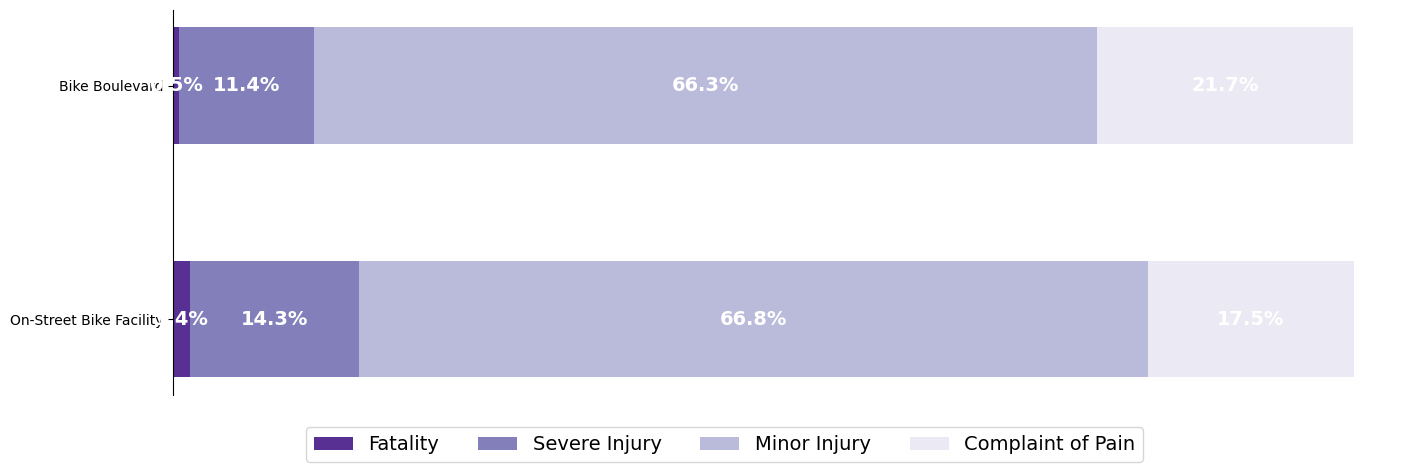

In [89]:
merged = [bp_points_in_bblvd_2, bp_points_out_bblvd_2]
result = pd.concat(merged)

severity_names = ['Fatality', 'Severe Injury','Minor Injury', 'Complaint of Pain']

injury_counts = {
    'Bike Boulevard': [0.5, 11.4, 66.3, 21.7],
    'On-Street Bike Facility': [1.4, 14.3, 66.8, 17.5]
}

bike_blvd_inj = injury_counts['Bike Boulevard']
onsbf_inj = injury_counts['On-Street Bike Facility']


bike_blvd_labels = []
onsbf_labels = []
for val in bike_blvd_inj:
    val_str = str(val)+'%'
    bike_blvd_labels.append(val_str)
for val2 in onsbf_inj:
    val2_str = str(val2)+'%'
    onsbf_labels.append(val2_str)
    
label_arr = np.column_stack((bike_blvd_labels, onsbf_labels))


def collision_summary(injury_counts, severity_names):
    labels = list(injury_counts.keys())
    data = np.array(list(injury_counts.values()))
    data_total = data.cumsum(axis=1)
    category_colors = plt.colormaps['Purples_r'](
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_title('Bike and Pedestrian Collision Severity', weight='bold', size=12)

    
    for i, (colname, color) in enumerate(zip(severity_names, category_colors)):
        widths = data[:, i]
        starts = (data_total[:, i] - widths)
        pct_label = label_arr[i]
        rects = ax.barh(labels, widths, left=starts, height=.5,
                        label=colname, color=color)
        
        text_color = 'white'
        ax.bar_label(rects, label_type='center', labels=pct_label, color=text_color, weight='bold', fontsize=14)
    ax.legend(ncols=4, bbox_to_anchor=(.79, -.2),
              loc='lower right', fontsize=14)
    
    return fig, ax



collision_summary(injury_counts, severity_names)

#plt.savefig('collision_sev_barchart.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()




In [90]:
injury_counts = {
    'Bike Boulevard': [0.5, 11.4, 66.3, 21.7],
    'On-Street Bike Facility': [1.4, 14.3, 66.8, 17.5]
}

bike_blvd_inj = injury_counts['Bike Boulevard']
print(bike_blvd_inj)
bike_blvd_labels = []
for val in bike_blvd_inj:
    val_str = str(val)+'%'
    bike_blvd_labels.append(val_str)



[0.5, 11.4, 66.3, 21.7]
